In [1]:
import datetime
import numpy as np
import pandas as pd
import random
import re
import time
from bs4 import BeautifulSoup

In [2]:
df=pd.read_json("data.jsonl",lines=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7082 entries, 0 to 7081
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   summary       7082 non-null   object
 1   description   7082 non-null   object
 2   project       7082 non-null   object
 3   customFields  7082 non-null   object
dtypes: object(4)
memory usage: 221.4+ KB


In [4]:
labels=df['customFields'].apply(lambda x: x.get('customfield_13901'))
sentence1=df['summary']
sentence2=df['description']

In [5]:
http_reg = re.compile(r'[h]?ttp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
path_reg = re.compile(r'/\w+(?:/\w+)*')

def clear_text(sentences):
    result = []
    for sentence in sentences:
        soup = BeautifulSoup(sentence)
        text = soup.get_text()
        text = text.replace("\r","")
        text = text.replace("\n","")    
        text = text.replace("\xa0"," ")
        text = text.strip()
        text = http_reg.sub('',text)    
        text = path_reg.sub('',text)    
        result.append(text)
    return pd.Series(result)

In [6]:
sentence1=clear_text(sentence1)
sentence2=clear_text(sentence2)

/tmp/ipykernel_6253/3062598911.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [7]:
unique_values_counts = labels.value_counts()

In [8]:
label_counts = range(0, 55, 5)

for threshold in label_counts:
    count_threshold = 0
    label_threshold = 0

    for index, count in labels.value_counts().items():
        if count < threshold:
            count_threshold += count
            label_threshold += 1

    print(f"---counts (threshold={threshold})---\n{threshold}:{count_threshold}")
    print(f"---labels (threshold={threshold})---\n{threshold}:{label_threshold}")


---counts (threshold=0)---
0:0
---labels (threshold=0)---
0:0
---counts (threshold=5)---
5:178
---labels (threshold=5)---
5:90
---counts (threshold=10)---
10:375
---labels (threshold=10)---
10:120
---counts (threshold=15)---
15:626
---labels (threshold=15)---
15:140
---counts (threshold=20)---
20:819
---labels (threshold=20)---
20:151
---counts (threshold=25)---
25:953
---labels (threshold=25)---
25:157
---counts (threshold=30)---
30:1058
---labels (threshold=30)---
30:161
---counts (threshold=35)---
35:1248
---labels (threshold=35)---
35:167
---counts (threshold=40)---
40:1284
---labels (threshold=40)---
40:168
---counts (threshold=45)---
45:1325
---labels (threshold=45)---
45:169
---counts (threshold=50)---
50:1417
---labels (threshold=50)---
50:171


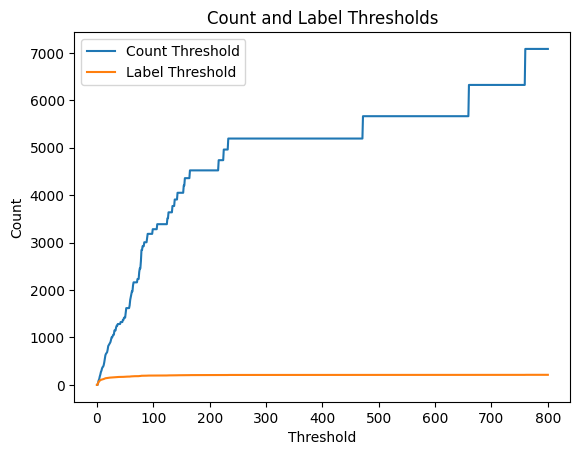

In [9]:
import matplotlib.pyplot as plt

label_counts = range(0, 801, 1)
count_results = []
label_results = []

for threshold in label_counts:
    count_threshold = 0
    label_threshold = 0

    for index, count in labels.value_counts().items():
        if count < threshold:
            count_threshold += count
            label_threshold += 1

    count_results.append(count_threshold)
    label_results.append(label_threshold)

plt.plot(label_counts, count_results, label='Count Threshold')
plt.plot(label_counts, label_results, label='Label Threshold')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.legend()
plt.title('Count and Label Thresholds')
plt.show()

In [10]:
max_len=0
for sentence in sentence2:
    if len(sentence)>max_len:
        max_len=len(sentence)
print(max_len)

7406


In [11]:
labels = labels.apply(lambda x: "Неизвестная система" if unique_values_counts[x] <= 100 else x)
unique_values_counts = labels.value_counts()
for value, count in unique_values_counts.items():
    print(f"Количество: {count}")

Количество: 3282
Количество: 759
Количество: 659
Количество: 471
Количество: 232
Количество: 224
Количество: 215
Количество: 164
Количество: 155
Количество: 153
Количество: 142
Количество: 137
Количество: 133
Количество: 126
Количество: 124
Количество: 106


In [12]:
unique_labels_count = len(set(labels))

print(f"Количество уникальных labels: {unique_labels_count}")

Количество уникальных labels: 16


начнем обучать модельку

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset,RandomSampler,SequentialSampler,random_split
from sklearn.preprocessing import LabelEncoder
import os
import torch

In [14]:
device="cuda"

In [15]:
model_name="ai-forever/ruBert-base"

tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=16,                       
    output_attentions=False,
    output_hidden_states=False,
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [16]:
sentences=sentence1+[". "]+sentence2

In [17]:
max_len = 0
sentences = sentence1 + ['.'] + sentence2

for sentence in sentence2:
    train_input_ids = tokenizer.encode(
        sentence,add_special_tokens=True)
    max_len=max(max_len, len(train_input_ids))

print('Максимальная длина текста: ', max_len)



Максимальная длина текста:  3950


понятно, что это слишком много, буду резать до 128

In [18]:
def encode(sentences):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      
                            add_special_tokens = True, 
                            max_length = 128,           
                            pad_to_max_length = True,  
                            return_attention_mask = True,   
                            return_tensors = 'pt',     
                    )

        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

In [19]:
input_ids, attention_masks = encode(sentences)
input_ids=torch.cat(input_ids,dim=0)
attention_masks=torch.cat(attention_masks,dim=0)

label_encoder = LabelEncoder()
labels=torch.tensor(label_encoder.fit_transform(labels))
labels.size(),input_ids.size(),attention_masks.size()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/vlamykin/git/NLP_OTUS_2023/env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(torch.Size([7082]), torch.Size([7082, 128]), torch.Size([7082, 128]))

In [20]:
dataset = TensorDataset(input_ids, attention_masks, labels)

In [21]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} образцов для обучения'.format(train_size))
print('{:>5,} образцов для валидации'.format(val_size))

6,373 образцов для обучения
  709 образцов для валидации


In [22]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=2e-4,   
                  eps=1e-8   
                )

In [24]:
epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

In [25]:
# Функция для вычисления точности наших предсказаний по сравнению с метками.
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
def format_time(elapsed):
    '''
    Принимает время в секундах и возвращает строку в формате чч:мм:сс.
    '''
    # Округляем до ближайшей секунды.
    elapsed_rounded = int(round(elapsed))

    # Форматируем как чч:мм:сс
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [27]:
output_dir = './model_save'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def model_save(epoch_i):
    print(f'saving model to {output_dir}/model_epoch_{epoch_i}')
    model.save_pretrained(f'{output_dir}/model_epoch_{epoch_i}')
    print(f'saving tokenizer to {output_dir}/tokemizer_epoch_{epoch_i}')
    tokenizer.save_pretrained(f'{output_dir}/tokenizer_epoch_{epoch_i}')

In [28]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Эпоха {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Обучение...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Батч {:>5,}  из  {:>5,}.    Затраченное время: {:}.'.format(step, len(train_dataloader), elapsed))
        #
        #
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("")
    print("  Средняя обучающая потеря: {0:.2f}".format(avg_train_loss))
    print("  Эпоха обучения заняла: {:}".format(training_time))
    print("")
    print("Запуск валидации...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        #
        #
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    model_save(epoch_i)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Точность: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Потери валидации: {0:.2f}".format(avg_val_loss))
    print("  Валидация заняла: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Обучающая потеря': avg_train_loss,
            'Потери на валидации': avg_val_loss,
            'Точность на валидации': avg_val_accuracy,
            'Время обучения': training_time,
            'Время валидации': validation_time
        }
    )
print("")
print("Обучение завершено!")
print("Всего обучение заняло {:} (ч:м:с)".format(format_time(time.time()-total_t0)))


======== Эпоха 1 / 4 ========
Обучение...
  Батч    50  из    200.    Затраченное время: 0:00:30.
  Батч   100  из    200.    Затраченное время: 0:01:01.
  Батч   150  из    200.    Затраченное время: 0:01:31.

  Средняя обучающая потеря: 1.42
  Эпоха обучения заняла: 0:02:02

Запуск валидации...
saving model to ./model_save/model_epoch_0
saving tokenizer to ./model_save/tokemizer_epoch_0
  Точность: 0.70
  Потери валидации: 1.01
  Валидация заняла: 0:00:05

======== Эпоха 2 / 4 ========
Обучение...
  Батч    50  из    200.    Затраченное время: 0:00:31.
  Батч   100  из    200.    Затраченное время: 0:01:02.
  Батч   150  из    200.    Затраченное время: 0:01:33.

  Средняя обучающая потеря: 0.79
  Эпоха обучения заняла: 0:02:05

Запуск валидации...
saving model to ./model_save/model_epoch_1
saving tokenizer to ./model_save/tokemizer_epoch_1
  Точность: 0.75
  Потери валидации: 0.88
  Валидация заняла: 0:00:05

======== Эпоха 3 / 4 ========
Обучение...
  Батч    50  из    200.    Зат